# Runtime Analysis
This notebook is designed to compare output two or more ACCESS-OM2 simulations. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38399 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


In [3]:
session = cc.database.create_session('ryf9091.db')

In [4]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_RYF8485',   {'expt':'01deg_jra55v13_ryf8485_spinup6','dir':'access-om2-01'}),
    ('025deg_RYF9091',  {'expt':'025deg_jra55v13_ryf9091_gmredi6','dir':'access-om2-025'})
                        ])

In [5]:
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    dir = exptdict[ekey]['dir']
    cc.database.build_index('/g/data/hh5/tmp/cosima/'+dir+'/'+expt,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf9091


100%|██████████| 198/198 [00:25<00:00,  7.76it/s]


Indexing experiment: 01deg_jra55v13_ryf8485_spinup6


0it [00:00, ?it/s]


Indexing experiment: 025deg_jra55v13_ryf9091_gmredi6


0it [00:00, ?it/s]


## Scalar diagnostics

In [12]:
def plot_timeseries(variable):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 20.2 s, sys: 1.52 s, total: 21.8 s
Wall time: 41.1 s


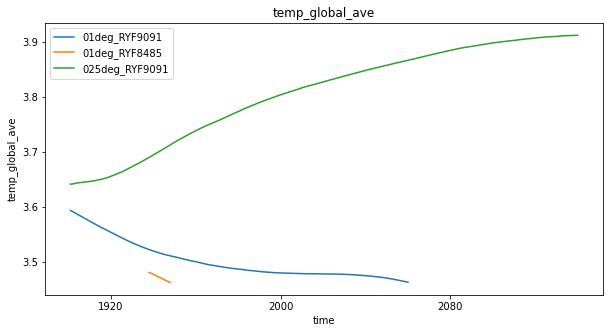

In [13]:
%%time
plot_timeseries('temp_global_ave')

### Global Average Salinity

CPU times: user 18.8 s, sys: 1.28 s, total: 20.1 s
Wall time: 34.9 s


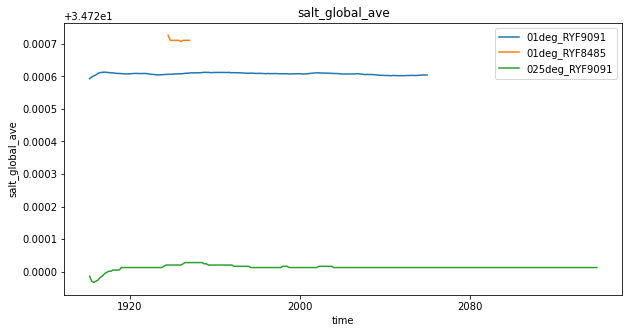

In [14]:
%%time
plot_timeseries('salt_global_ave')

### Surface Temperature

CPU times: user 17.8 s, sys: 1.23 s, total: 19 s
Wall time: 33.5 s


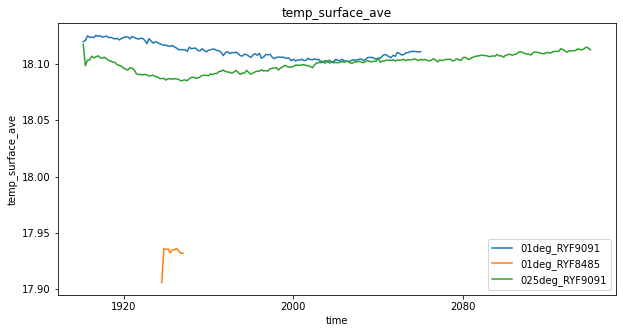

In [15]:
%%time
plot_timeseries('temp_surface_ave')

### Surface Salinity

CPU times: user 19.6 s, sys: 1.23 s, total: 20.8 s
Wall time: 36.3 s


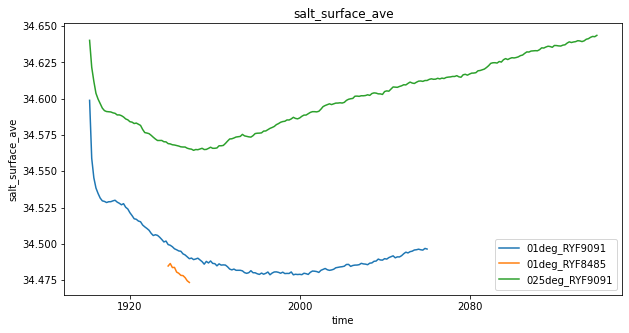

In [16]:
%%time
plot_timeseries('salt_surface_ave')

### Total Kinetic Energy

CPU times: user 19.2 s, sys: 1.13 s, total: 20.3 s
Wall time: 35.9 s


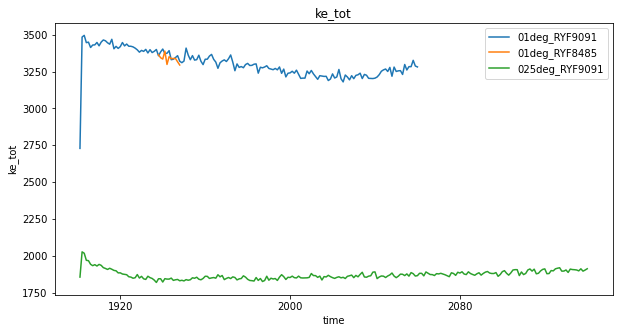

In [17]:
%%time
plot_timeseries('ke_tot')

## Area-Averaged Tracer Diagnostics

In [18]:
def plot_upper_ocean(variable):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc')
        varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

01deg_jra55v13_ryf9091


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 50min 46s, sys: 4min 2s, total: 54min 48s
Wall time: 1h 17min 2s


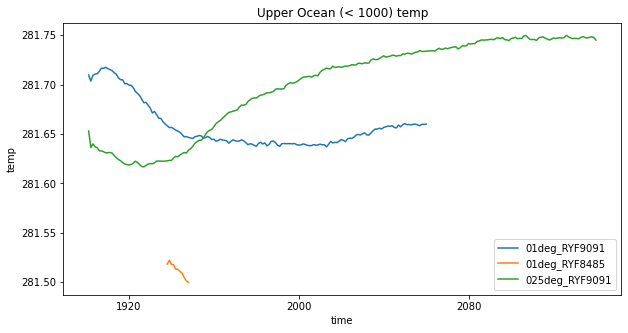

In [19]:
%%time
plot_upper_ocean('temp')

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 52min 26s, sys: 4min 15s, total: 56min 42s
Wall time: 1h 20min


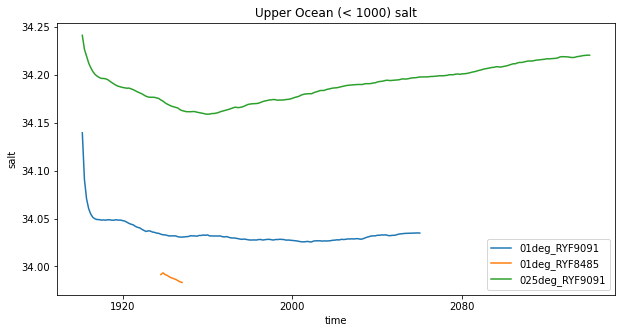

In [20]:
%%time
plot_upper_ocean('salt')

### Deep Ocean Temperature/Salinity

In [21]:
def plot_lower_ocean(variable):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc')
        varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

In [ ]:
%%time
plot_lower_ocean('temp')

01deg_jra55v13_ryf9091


In [ ]:
%%time
plot_lower_ocean('salt')

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 47.1 s, sys: 2.77 s, total: 49.8 s
Wall time: 1min 37s


Text(0.5, 1.0, 'ACC Transport')

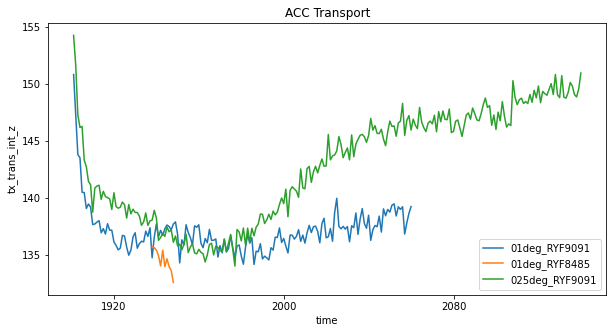

In [6]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 15min 18s, sys: 34.4 s, total: 15min 53s
Wall time: 19min 17s


Text(0.5, 1.0, 'AABW Cell')

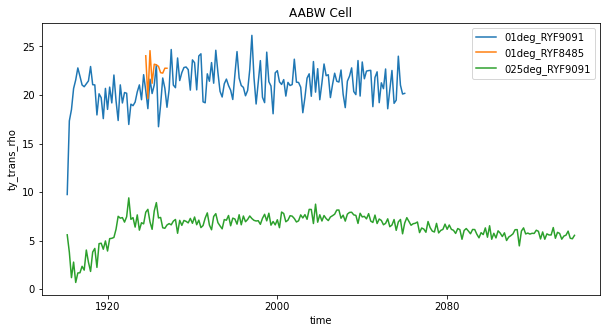

In [7]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 8min 24s, sys: 19.7 s, total: 8min 43s
Wall time: 11min 1s


Text(0.5, 1.0, 'AMOC Cell')

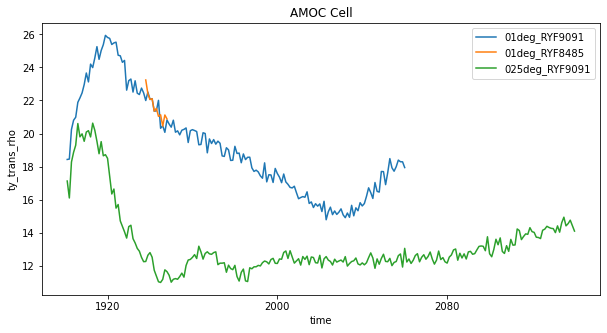

In [8]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

In [10]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    plt.figure(figsize=(12,8))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

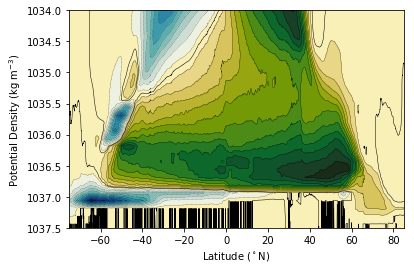

In [8]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='1950-01-01', end_time='1960-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
plot_psi(psi_avg)

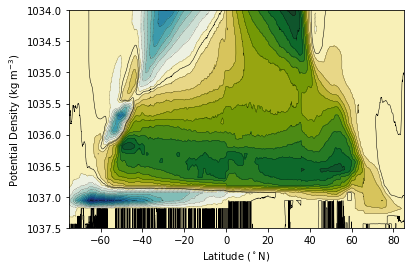

In [9]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2000-01-01', end_time='2010-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
plot_psi(psi_avg)

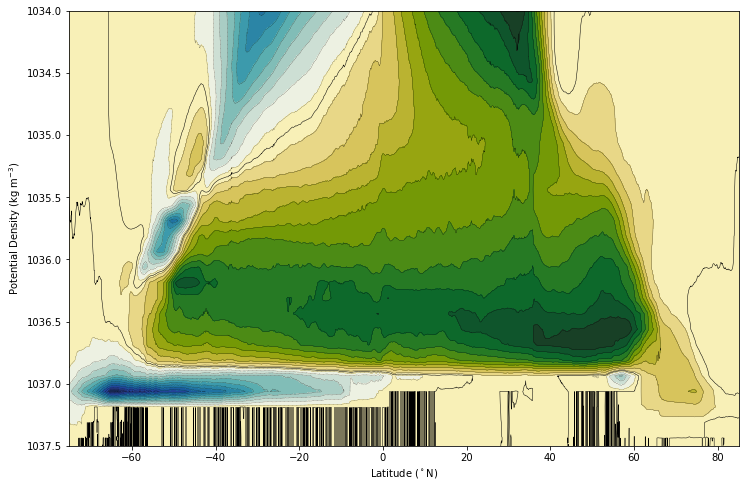

In [11]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2050-01-01', end_time='2060-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
plot_psi(psi_avg)

### Ice Area (in both hemispheres)

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 720x648 with 0 Axes>

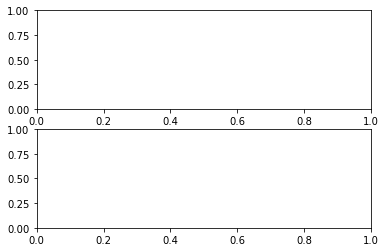

In [23]:
variable='aice_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')